# Time Series Analysis For Stock Data

Time series data has the special property of being time dependent - observations for a single process or subject have a chronological order. Data points are therefore correlated with each other and violate the independent indentically distributed assumption that many regression-type models rely upon. Thus, time series data requires new methods for its analysis. One common class of models is the ARIMA model, or the auto-regressive integrated moving average model. It makes the important assumption of **stationarity**.  

## Stationarity

stationarity: if lags don't depend on time, which can be verified by stable/near-constant mean and variance
check stationarity using hypothesis tests, such as ADF test or KPSS test
many traditional models assume stationarity - which can be achieved through square root or log transforms in some cases

also need to check normality of input vars and output vars

autocorrelation: how data points in different points in time are linearly related to each other as a function of time difference
ACF function: computes correlation between a dataset and the same dataset lagged k = 1, 2, ... , m times
PACF: eliminates some of the redundancies in ACF, effectively providing a more informative succinct summary 
autocorr that falls within a critical region is effectively zero 
partial autocorrelation is the correlation of two residuals obtained after regressing X_k+1 and X_1 on the intermediate observations X_2, ..., X_k

predicting too far into the future results in the training data becoming irrelevant aside from the mean value, the predictions will tend toward the mean of the process and the variance will tend toward 0

For AR model, use PACF to determine how many lags to include(the point at which no more lags are above the sig threshold is the chosen lag). The PACF at lag terms after the model order are theoretically zero, so there should be a sharp visible cutoff 

For MA model, use ACF since lag terms after the model order are theoretically zero.

AR and MA use opposing methods because they are "invertible" if the coefficients are within the unit circle, that is an AR or MA process with finite terms can be reexpressed as an infinite process of the other model. This means one can approxmate AR or MA using a lower order ARMA model 
https://stats.stackexchange.com/questions/112932/interpretation-of-the-partial-autocorrelation-function-for-a-pure-ma-process?rq=1

difference before or within arima https://stats.stackexchange.com/questions/471512/do-differencing-within-arima-or-do-differencing-first-before-fitting-arima

can approximate ARIMA(p,d,q) using ARMA(p+d,q) https://stats.stackexchange.com/questions/209727/arma-when-arima-should-be-used

statsmodels uses statespace estimation for parameter estimation rather than more traditional methods like MLE and Yule-Walker equations, just something to keep in mind

In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
data = yf.download(tickers = ['MSFT'], start = '2016-08-01', end = '2021-08-01', period = '1mo', interval = '1mo', 
                   group_by = 'ticker', auto_adjust = True, prepost = False, threads = True, proxy = None)
data = data.dropna(axis = 0)

[*********************100%***********************]  1 of 1 completed


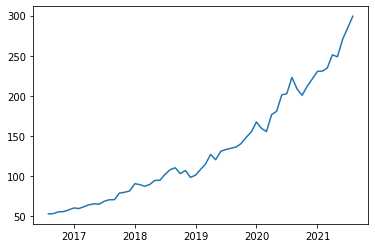

In [3]:
plt.plot(data['Close'])
plt.show()

In [4]:
adf_test = dict(zip(['Test Statistic','p-value','#Lags Used','Number of Observations Used'], 
                    list(sm.tsa.stattools.adfuller(data['Close'], autolag='AIC')[:4])))
print(adf_test)

{'Test Statistic': 3.586276100025394, 'p-value': 1.0, '#Lags Used': 11, 'Number of Observations Used': 49}


p-value is above significance level of 0.05, we fail to reject the null hypothesis that the series has a unit root, i.e. that it is nonstationary. 

In [5]:
kpss_test = dict(zip(['Test Statistic','p-value','Lags Used'],
                     list(sm.tsa.stattools.kpss(data['Close'], nlags='auto')[:3])))
print(kpss_test)

{'Test Statistic': 1.2656743729932256, 'p-value': 0.01, 'Lags Used': 4}


c:\users\user\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


KPSS test has a significant p-value, so we reject the null hypothesis that the series is stationary. stationarity can be fixed with differencing.

In [6]:
def diff(seq, lag = 1):
    return(seq[lag:] - seq[:(len(seq) - lag)])

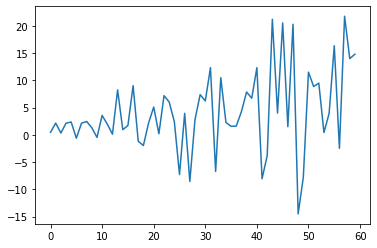

In [7]:
plt.plot(diff(data['Close'].values))
plt.show()

In [8]:
adf_test = dict(zip(['Test Statistic','p-value','#Lags Used','Number of Observations Used'], 
                    list(sm.tsa.stattools.adfuller(diff(data['Close'].values), autolag='AIC')[:4])))
print(adf_test)

kpss_test = dict(zip(['Test Statistic','p-value','Lags Used'],
                     list(sm.tsa.stattools.kpss(diff(data['Close'].values), nlags='auto')[:3])))
print(kpss_test)

{'Test Statistic': -8.158366074599547, 'p-value': 9.286855820245664e-13, '#Lags Used': 0, 'Number of Observations Used': 59}
{'Test Statistic': 0.688074382305669, 'p-value': 0.014629601608575547, 'Lags Used': 2}


We can see that after one order of differencing(order being the number of times we difference), the series is now stationary according to both aforementioned tests. Thus we can move onto modeling the differenced data in good conscience. 

While it is certainly possible to manually difference time series data before fitting a model to it, it is usually preferable to allow the model to perform the differencing. This mitigates the chances of human error as well as makes it easier to compute things like fitted values and forecasts(which requires undifferencing via cumulative sums). What's more, fitted values of already differenced data can't be undifferenced to yield fitted values of undifferenced data. Basically, leave the differencing to the function. 

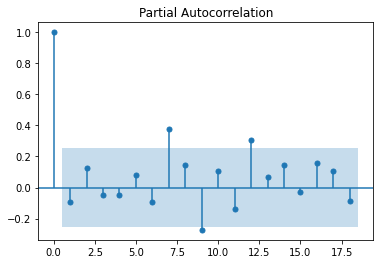

In [9]:
data_stationary = diff(data['Close'].values)
sm.graphics.tsa.plot_pacf(data_stationary)
plt.show()

In [10]:
ar = sm.tsa.arima.ARIMA(data['Close'].values, order = (7,1,0))
ar_res = ar.fit()
print(ar_res.summary())
#res.plot_diagnostics(figsize=(10, 10))
#plt.show()
# https://analyzingalpha.com/interpret-arima-results

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:                 ARIMA(7, 1, 0)   Log Likelihood                -201.313
Date:                Sun, 29 Aug 2021   AIC                            418.626
Time:                        21:05:09   BIC                            435.381
Sample:                             0   HQIC                           425.179
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0183      0.125      0.146      0.884      -0.227       0.263
ar.L2          0.1505      0.103      1.463      0.143      -0.051       0.352
ar.L3          0.0322      0.162      0.198      0.8

c:\users\user\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


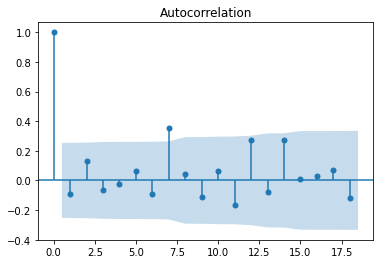

In [11]:
sm.graphics.tsa.plot_acf(diff(data['Close'].values))
plt.show()

In [12]:
ma = sm.tsa.arima.ARIMA(data['Close'].values, order = (0,1,7))
ma_res = ma.fit()
print(ma_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:                 ARIMA(0, 1, 7)   Log Likelihood                -202.266
Date:                Sun, 29 Aug 2021   AIC                            420.532
Time:                        21:05:09   BIC                            437.287
Sample:                             0   HQIC                           427.086
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0805      0.165      0.489      0.625      -0.242       0.403
ma.L2          0.3309      0.092      3.585      0.000       0.150       0.512
ma.L3          0.0799      0.146      0.549      0.5

In [13]:
arma = sm.tsa.arima.ARIMA(data['Close'].values, order = (7,1,7))
arma_res = arma.fit()
print(arma_res.summary())

c:\users\user\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\user\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:                 ARIMA(7, 1, 7)   Log Likelihood                -196.368
Date:                Sun, 29 Aug 2021   AIC                            422.736
Time:                        21:05:10   BIC                            454.151
Sample:                             0   HQIC                           435.024
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3439      0.644      0.534      0.593      -0.918       1.606
ar.L2         -0.1065      0.641     -0.166      0.868      -1.363       1.150
ar.L3         -0.0777      0.261     -0.297      0.7

c:\users\user\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
import pmdarima as pm
auto_fit = pm.auto_arima(data['Close'].values, start_p=1, start_q=1,
                         max_p=10, max_q=10,
                         d=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
print(auto_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=417.322, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=414.326, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=415.824, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=415.922, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=428.454, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.084 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -205.163
Date:                Sun, 29 Aug 2021   AIC                            414.326
Time:                        21:09:35   BIC                            418.515
Sample:                             0   HQIC                           415.964
                                 - 61                                         
Co

## State Space Models